# DEM-SRNet: Super-resolution Reconstruction of A 3 Arc-second Global DEM Dataset

[![DownloadNotebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook_en.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindearth/en/dem-super-resolution/mindspore_DEM-SRNet.ipynb)&emsp;[![DownloadCode](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code_en.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindearth/en/dem-super-resolution/mindspore_DEM-SRNet.py)&emsp;[![View Source On Gitee](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source_en.svg)](https://gitee.com/mindspore/docs/blob/master/docs/mindearth/docs/source_en/dem-super-resolution/DEM-SRNet.ipynb)


## Overview

DEM-SRNet, short for digital elevation model network, can provide accurate basic geographical data and therefore plays a vital role in research fields such as global climate change, ocean tidal movement, and material exchange on the Earth's sphere. The key theoretical and technological obstacles to fine modeling must be overcome before the geographical distribution of ocean topography and plate movement patterns can be explored. Finer than 100-m resolution global DEMs were not available until the 2020s, when the world's 30-m resolution land NASADEM and FABDEM were made freely available. Because of the large quantity of data, it takes more time and requires more computational resources to make global DEM maps with higher resolution. These data fusions have various accuracy difficulties because of the different resolutions and sensors. A deep learning technique known as super-resolution (SR) has been used to identify and compensate for the differences between resolutions and sensors. The 30-m resolution NASADEM, GEBCO_2021 data, and numerous high-resolution (HR) regional ocean DEM datasets are all publicly available, making it feasible to generate a global DEM dataset with a 3 arc-second resolution.

This tutorial introduces the research background and technical path of DEM-SRNet, and shows how to train and fast infer the model through MindEarth. More information can be found in [paper](https://pubmed.ncbi.nlm.nih.gov/36604030/).

## Technology Path

MindEarth solves the problem as follows:

1. Training Data Construction.
2. Model Construction.
3. Loss function.
4. Model Training.
5. Model Evaluation and Visualization.

## DEM-SRNet

A deep residual network called DEM-SRNet is proposed to pretrain the terrestrial DEM data. As illustrated in Figure, the designed pre-training structure is derived from the enhanced deep super-resolution network(EDSR). The first convolutional layer of the pre-trained DEM-SRNet network extracts a collection of features. The EDSR models default number of residual blocks was expanded to 32. Through experimental comparison, the optimal number of residual blocks(ResBlocks) is 42, each of which is composed of two convolutional layers that are interpolated with a ReLU activation function and finally, followed by a convolutional layer and an element-wise addition layer. This latter includes a convolution layer for extracting feature maps; an interpolating layer with a scale factor of 5 is utilized for upsampling from an input low resolution of 15 arc-second data to a target high resolution of 3 arc-second data; and finally, the convolutional layer aggregates the feature maps in the low-resolution space and generates the SR output data. With the interpolation function layer, low-resolution data can be super-resolution without checkerboard artifacts, as opposed to typical deconvolutional layers.

The network is made up of 88 convolutional layers, 43 elementwise addition layers, and one interpolating layer. The convolutional kernel size in each convolutional layer is set to 3, and the padding is set to 1. There are 50,734,080 network parameters in total. The Adam optimizer with an initial learning rate of 0.0001 and the exponential decay method are used to train the model with the large dataset during the training phase. The early stopping technique with a patience of 6 is used to terminate training when the model’s performance begins to deteriorate in the validation set to prevent overfitting. The mini-batch gradient descent method typically requires 300 epochs to build a pre-training network from scratch. The initial parameters are derived from the terrestrial data pre-training network. The freeze layers of the pre-training network are employed in conjunction with the limited HR ocean DEMs to fine-tune the global DEM-SR model. As fine-tuning samples are limited, the learning rate has a significant impact on the convergence process. The learning rate is then adjusted down to 0.00001.

![DEM_SR](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/docs/mindearth/docs/source_en/dem-super-resolution/images/dem_Dem_Sr.png)

Model training consists of two steps:

1. Pre-training: As shown in Figure above, in the pre-training step, the first convolutional layer of the pre-trained DEM-SRNet network extracts a collection of features. The EDSR models default number of residual blocks was expanded to 32.

2. Fine tuning: The main contribution of this paper is pre-training the neural network model with GEBCO_2021 and NASADEM land samples, followed by additional fine-tuning with limited regional ocean DEM data.



In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from mindspore import context, nn, Tensor
from mindspore import load_checkpoint, load_param_into_net
from mindspore.train import LossMonitor, TimeMonitor

from mindearth.utils import load_yaml_config, create_logger
from mindearth.module import Trainer
from mindearth.data import DemData, Dataset

The following `src` can be downloaded in [DEM super-resolution/src](https://gitee.com/mindspore/mindscience/tree/master/MindEarth/applications/dem-super-resolution/src).

In [2]:
from src import init_model, plt_dem_data
from src import EvaluateCallBack, InferenceModule

context.set_context(mode=context.GRAPH_MODE, device_target="Ascend", device_id=0)


You can get parameters of model, data and optimizer from [DEM-SRNet.yaml](https://gitee.com/mindspore/mindscience/blob/master/MindEarth/applications/dem-super-resolution/DEM-SRNet.yaml).

In [3]:
config = load_yaml_config('DEM-SRNet.yaml')

config['train']['distribute'] = False # set the distribute feature
config['train']['amp_level'] = 'O2' # set the level for mixed precision training
config["train"]["load_ckpt"] = False # set the checkpoint load feature

config['data']['num_workers'] = 1  # set the number of parallel workers
config['data']['epochs'] = 100 # set the train epochs

config['summary']["valid_frequency"] = 100 # set the frequency of validation
config['summary']["summary_dir"] = './summary' # set the directory of model's checkpoint

logger = create_logger(path=os.path.join(config['summary']["summary_dir"], "results.log"))

## Training Data Construction

Download the training, validation and test datasets from [dataset](https://download.mindspore.cn/mindscience/mindearth/dataset/dem_dataset.zip) to `./dataset`.

Modify the parameter of `root_dir` in the [DEM-SRNet.yaml](https://gitee.com/mindspore/mindscience/blob/master/MindEarth/applications/dem-super-resolution/DEM-SRNet.yaml), which set the directory for dataset.

The `./dataset` is hosted with the following directory structure:

```markdown
.
├── train
│   └── train.h5
├── valid
│   └── valid.h5
├── test
│   └── test.h5
```


## Model Construction

Initialize the DEM model.

In [4]:
model = init_model(config)

## Loss Function

DEM-SRNet uses mean squared error for model training.

In [5]:
loss_fn = nn.MSELoss()

## Model Training

In this tutorial, we inherite the Trainer and override the get_callback member function so that we can perform inference on the test dataset during the training process.

With MindSpore version >= 1.10.1, we can use the functional programming for training neural networks. MindEarth provides a training interface for model training.

In [6]:
class DemSrTrainer(Trainer):
    r"""
    Self-define forecast model inherited from `Trainer`.

    Args:
        config (dict): parameters for training.
        model (Cell): network for training.
        loss_fn (str): user-defined loss function.
        logger (logging.RootLogger): tools for logging.

    Supported Platforms:
        ``Ascend`` ``GPU``

    """
    def __init__(self, config, model, loss_fn, logger):
        super(DemSrTrainer, self).__init__(config, model, loss_fn, logger, weather_data_source="DemSR")
        self.model = model
        self.optimizer_params = config["optimizer"]
        self.train_dataset, self.valid_dataset = self.get_dataset()
        self.optimizer = self.get_optimizer()
        self.solver = self.get_solver()

    def get_optimizer(self):
        r"""define the optimizer of the model, abstract method."""
        self.steps_per_epoch = self.train_dataset.get_dataset_size()
        if self.logger:
            self.logger.info(f'steps_per_epoch: {self.steps_per_epoch}')
        if self.optimizer_params['name']:
            optimizer = nn.Adam(self.model.trainable_params(),
                                learning_rate=Tensor(self.optimizer_params['learning_rate']))
        else:
            raise NotImplementedError(
                "self.optimizer_params['name'] not implemented, please overwrite get_optimizer()")
        return optimizer

    def get_callback(self):
        r"""define the callback of the model, abstract method."""
        pred_cb = EvaluateCallBack(self.model, self.valid_dataset, self.config, self.logger)
        return pred_cb

    def train(self):
        r""" train """
        callback_lst = [LossMonitor(), TimeMonitor(), self.ckpt_cb]
        if self.pred_cb:
            callback_lst.append(self.pred_cb)
        self.solver.train(epoch=config['data']['epoch_size'],
                          train_dataset=self.train_dataset,
                          callbacks=callback_lst,
                          dataset_sink_mode=True)
trainer = DemSrTrainer(config, model, loss_fn, logger)

2023-09-27 10:33:38,449 - 3395036387.py[line:27] - INFO: steps_per_epoch: 109


In [7]:
trainer.train()

epoch: 1 step: 109, loss is 0.0018688203
Train epoch time: 55616.483 ms, per step time: 510.243 ms
epoch: 2 step: 109, loss is 0.0008327974
Train epoch time: 31303.473 ms, per step time: 287.188 ms
epoch: 3 step: 109, loss is 0.00022218125
...
epoch: 98 step: 109, loss is 1.3421039e-05
Train epoch time: 29786.506 ms, per step time: 273.271 ms
epoch: 99 step: 109, loss is 1.113452e-05
Train epoch time: 31082.307 ms, per step time: 285.159 ms
epoch: 100 step: 109, loss is 2.0731915e-05
Train epoch time: 30750.022 ms, per step time: 282.110 ms


## Model Evaluation and Visualization

In [8]:
params = load_checkpoint("./summary/ckpt/step_/DemSrNet_7-100_109.ckpt")
load_param_into_net(model, params)

inference_module = InferenceModule(model, config, logger)
test_dataset_generator = DemData(data_params=config["data"], run_mode='test')
test_dataset = Dataset(test_dataset_generator, distribute=False,
                       num_workers=config["data"]['num_workers'], shuffle=False)
test_dataset = test_dataset.create_dataset(config["data"]['batch_size'])
create_test_data = test_dataset.create_dict_iterator()

The following figure visualizes the true and predicted values for the 100th model.

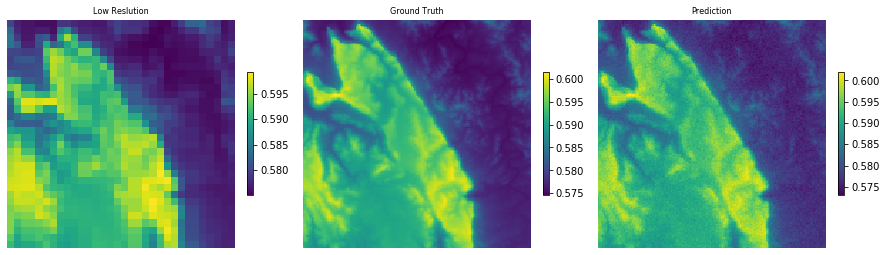

In [9]:
data = next(create_test_data)

inputs = data['inputs']
labels = data['labels']

low_res = inputs[0].asnumpy()[0].astype(np.float32)
pred = inference_module.forecast(inputs)
pred = pred[0].asnumpy()[0].astype(np.float32)
label = labels[0].asnumpy()[0].astype(np.float32)

plt.figure(num='e_imshow', figsize=(15, 36))
plt.subplot(1, 3, 1)
plt_dem_data(low_res, "Low Reslution")
plt.subplot(1, 3, 2)
plt_dem_data(label, "Ground Truth")
plt.subplot(1, 3, 3)
plt_dem_data(pred, "Prediction")
